LOADING DATA INTO THE NOTEBOOK

In [1]:
import pandas as pd

# Load company information
company_info = pd.read_csv('company_info.csv')

# Load company stock details
company_stock_details = pd.read_csv('company_stock_details.csv')

# Display the first few rows to understand the structure
print(company_info.head())
print(company_stock_details.head())

  Symbol  GICS Sector    Headquarters Location      Founded
0    MMM  Industrials    Saint Paul, Minnesota         1902
1    AOS  Industrials     Milwaukee, Wisconsin         1916
2    ABT  Health Care  North Chicago, Illinois         1888
3   ABBV  Health Care  North Chicago, Illinois  2013 (1888)
4   ABMD  Health Care   Danvers, Massachusetts         1981
        Date       Close   Volume Symbol  News - Positive Sentiment  \
0  30/9/2020  160.179993  3056900    MMM                        NaN   
1  1/10/2020  158.789993  1989100    MMM                        0.0   
2  2/10/2020  160.360001  1768600    MMM                        3.0   
3  5/10/2020  162.750000  1457000    MMM                        2.0   
4  6/10/2020  162.229996  2021900    MMM                        0.0   

   News - Negative Sentiment  News - New Products  News - Layoffs  \
0                        NaN                  NaN             NaN   
1                        0.0                  0.0             0.0   
2     

CLEAN DATA

In [2]:
print(company_info.isnull().sum())
print(company_stock_details.isnull().sum())

Symbol                   0
GICS Sector              0
Headquarters Location    0
Founded                  0
dtype: int64
Date                               0
Close                              0
Volume                             0
Symbol                             0
News - Positive Sentiment        493
News - Negative Sentiment        493
News - New Products              493
News - Layoffs                   493
News - Analyst Comments          493
News - Stocks                    493
News - Dividends                 493
News - Corporate Earnings        493
News - Mergers & Acquisitions    493
News - Store Openings            493
News - Product Recalls           493
News - Adverse Events            493
News - Personnel Changes         493
News - Stock Rumors              493
dtype: int64


HANDLING MISSING VALUES

In [3]:
company_stock_details.fillna(method='ffill', inplace=True)

C:\Users\alaga\AppData\Local\Temp\ipykernel_32104\2554499657.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  company_stock_details.fillna(method='ffill', inplace=True)


MERGING NEW DATA

In [4]:
# Perform an inner join to merge on 'Symbol' (this only keeps rows where there is a match)
merged_data = pd.merge(company_stock_details, company_info, on='Symbol', how='inner')

# Check the first few rows of the merged data
print(merged_data.head())

# Save the merged data into a new CSV file
merged_data.to_csv('merged_company_data.csv', index=False)

        Date       Close   Volume Symbol  News - Positive Sentiment  \
0  30/9/2020  160.179993  3056900    MMM                        NaN   
1  1/10/2020  158.789993  1989100    MMM                        0.0   
2  2/10/2020  160.360001  1768600    MMM                        3.0   
3  5/10/2020  162.750000  1457000    MMM                        2.0   
4  6/10/2020  162.229996  2021900    MMM                        0.0   

   News - Negative Sentiment  News - New Products  News - Layoffs  \
0                        NaN                  NaN             NaN   
1                        0.0                  0.0             0.0   
2                        0.0                  0.0             0.0   
3                        3.0                  0.0             0.0   
4                        0.0                  0.0             0.0   

   News - Analyst Comments  News - Stocks  ...  News - Corporate Earnings  \
0                      NaN            NaN  ...                        NaN   
1   

CREATING LAGGED VARIABLES


In [5]:
merged_data['Close_lag_1'] = merged_data.groupby('Symbol')['Close'].shift(1)
merged_data['Close_lag_2'] = merged_data.groupby('Symbol')['Close'].shift(2)
merged_data['Close_lag_3'] = merged_data.groupby('Symbol')['Close'].shift(3)
merged_data['Close_lag_4'] = merged_data.groupby('Symbol')['Close'].shift(4)
merged_data['Close_lag_5'] = merged_data.groupby('Symbol')['Close'].shift(5)

IMPROVING THEM FURTHER

In [6]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data['Day'] = merged_data['Date'].dt.day
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Weekday'] = merged_data['Date'].dt.weekday

C:\Users\alaga\AppData\Local\Temp\ipykernel_32104\3375785028.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_data['Date'] = pd.to_datetime(merged_data['Date'])


TRAIN TEST SPLIT

In [7]:
# Sort by date to maintain chronological order
merged_data.sort_values(by=['Symbol', 'Date'], inplace=True)

# Define the split date
train_data = merged_data[merged_data['Date'] < '2022-01-01']
test_data = merged_data[merged_data['Date'] >= '2022-01-01']

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


LOADING UP FOR SARIMA

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

DOING PACF (ALSO ISOLATE TO JUST ONE COMPANY FIRST)

C:\Users\alaga\AppData\Local\Temp\ipykernel_32104\3920110932.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('company_stock_details.csv', parse_dates=['Date'], index_col='Date')


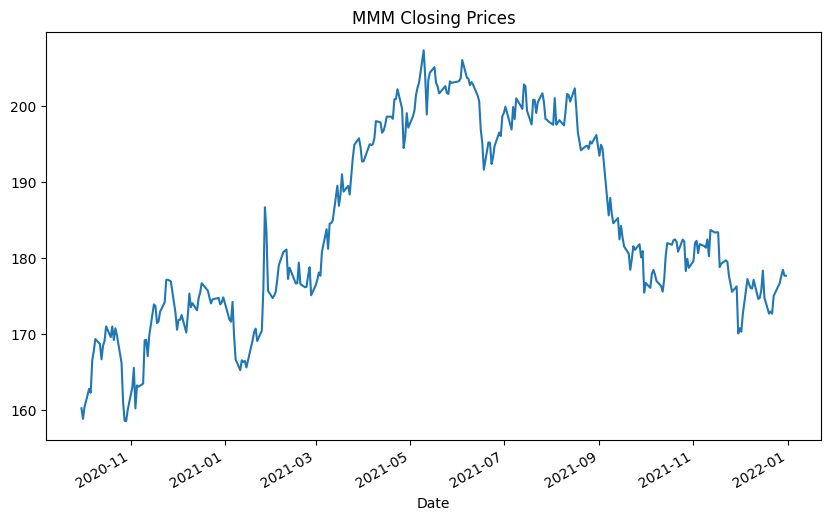

In [9]:
# Load the stock price data
data = pd.read_csv('company_stock_details.csv', parse_dates=['Date'], index_col='Date')
train_data = data[data.index < '2022-01-01']
# Filter for one company, for example 'MMM'
mmm_data = train_data[train_data['Symbol'] == 'MMM']

# Visualize the closing price over time
mmm_data['Close'].plot(title='MMM Closing Prices', figsize=(10, 6))
plt.show()

I am visually inferring that this data is not stationary looking at the graph, as the mean from 2020 october to 2022 january, is vastly different from the mean from 2022 january to 2022 july. Although, it is indeed worth mentioning that I think the standard deviation is constant, and I do not infer any direct seasonality from my naked eye. Regardless, let us test it out via code.

CHECKING STATIONARITY

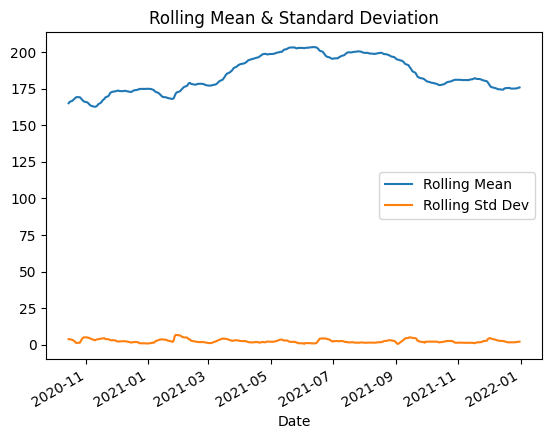

In [10]:
mmm_data['Close'].rolling(window=12).mean().plot(label='Rolling Mean')
mmm_data['Close'].rolling(window=12).std().plot(label='Rolling Std Dev')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

I used a rolling mean of 12 days, (after going past 12 datapoints, rolling mean uses the mean close of first 12 datapoints to create its first datapoint, then second datapoint is the 2nd to 13th datapoint, third datapoint is 3rd to 14th, so on so forth)

So I need to attempt to make this stationary, and how I will go about doing it is bringing forth the "integrated" aspect of ARIMA. Finding the differences between each datapoint, and then dropping the first difference as it is NA because it has no datapoint to difference off of, and plotting the differences instead.

C:\Users\alaga\AppData\Local\Temp\ipykernel_32104\4237357028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmm_data['Diff_Close'] = mmm_data['Close'].diff().dropna()


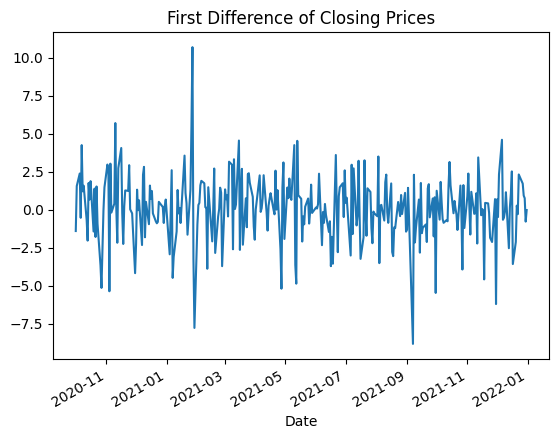

In [11]:
# Differencing the data
mmm_data['Diff_Close'] = mmm_data['Close'].diff().dropna()
mmm_data['Diff_Close'].plot(title='First Difference of Closing Prices')
plt.show()

This looks better stationarity wise.

PLOTTING PACF AND ACF

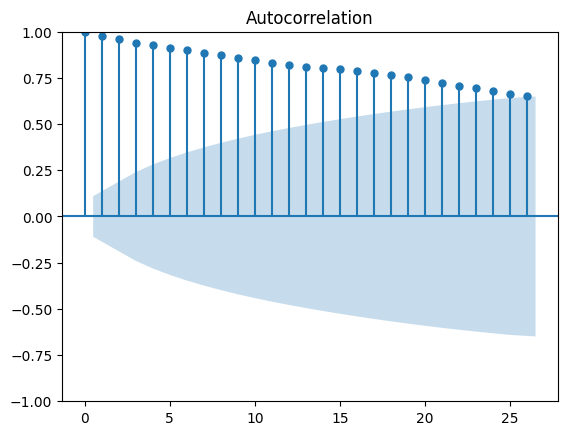

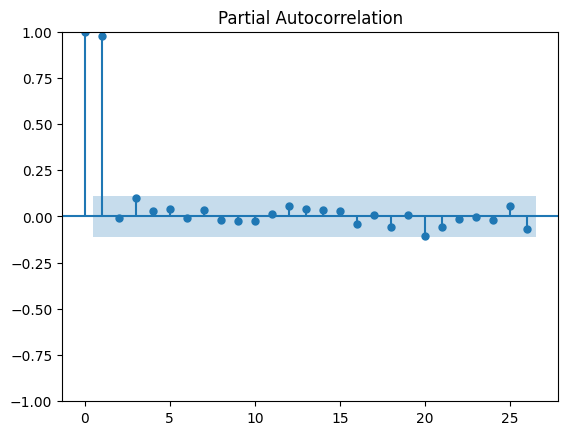

In [12]:
plot_acf(mmm_data['Close'].dropna())
plt.show()

plot_pacf(mmm_data['Close'].dropna())
plt.show()


I can conclude that this is an AR1 model, where we are basing the current variable with the most recent lagged variable.

However, in my learning curve while building this model, I have realised I need to confirm the non-stationarity of the data. Hence, I ran an Augmented Dickey Fuller test, to check whether the co-efficient I obtained off of the PACF test for the most recent lagged variable, is an unit root or not. If it is an unit root, meaning it equals to 1, that 

In [13]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the 'Close' prices
adf_result = adfuller(mmm_data['Close'])

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary (cannot reject null hypothesis).")
else:
    print("The time series is likely stationary (reject null hypothesis).")

ADF Statistic: -1.982859340445174
p-value: 0.29413888031519664
Critical Values: {'1%': np.float64(-3.4513486122290717), '5%': np.float64(-2.870789013306053), '10%': np.float64(-2.5716978530569192)}
The time series is likely non-stationary (cannot reject null hypothesis).


I also wanted to literally find the co-efficient of the most recent lagged variable under partial auto correlation to check whether it has an unit root or not.

In [14]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AutoRegressive (AR) model to the closing prices
# The 'lags' parameter controls how many lagged terms to include (for example, AR(1) or AR(2))
closing_prices=mmm_data['Close']
ar_model = AutoReg(closing_prices, lags=1).fit()

# Print the AR coefficient(s) (rho values)
print("AR coefficients (rho):")
print(ar_model.params)



AR coefficients (rho):
const       3.796147
Close.L1    0.979670
dtype: float64


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


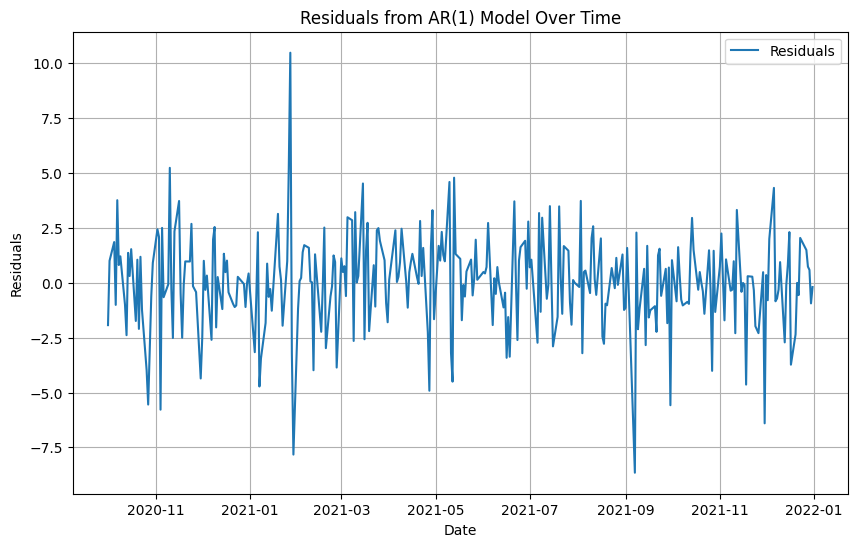

In [15]:
# Get the residuals of the AR model
residuals = ar_model.resid

# Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.title('Residuals from AR(1) Model Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()



In [16]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs(residuals) / closing_prices[1:]).mean() * 100

# Print the MAPE result
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 0.87%


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in

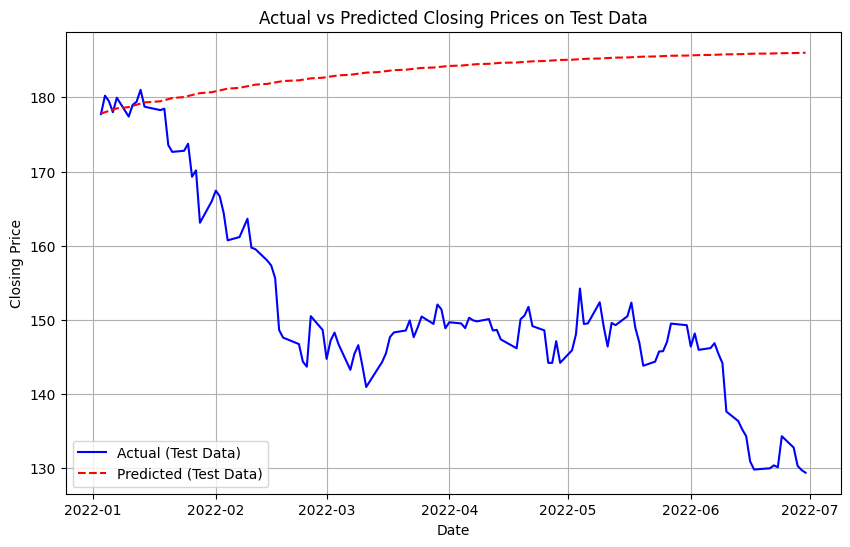

Mean Absolute Percentage Error (MAPE) on Test Data: 21.86%


In [17]:
# Split the data into train and test based on the date
train_data = data[data.index < '2022-01-01']
test_data = data[data.index >= '2022-01-01']

# Filter for one company, for example 'MMM'
train_mmm_data = train_data[train_data['Symbol'] == 'MMM']
test_mmm_data = test_data[test_data['Symbol'] == 'MMM']

# Train AutoRegressive (AR) model using the training data
closing_prices_train = train_mmm_data['Close']
ar_model = AutoReg(closing_prices_train, lags=1).fit()

# Predict the test data
# Note: The start and end indices for predict must match the test data range
predicted_values = ar_model.predict(start=len(closing_prices_train), 
                                    end=len(closing_prices_train) + len(test_mmm_data) - 1, 
                                    dynamic=False)

# Align the predicted values with the test set's index
predicted_values.index = test_mmm_data.index

# Plot actual vs predicted values on test data
plt.figure(figsize=(10, 6))

# Plot actual closing prices from test data
plt.plot(test_mmm_data.index, test_mmm_data['Close'], label='Actual (Test Data)', color='blue')

# Plot predicted closing prices from test data
plt.plot(predicted_values.index, predicted_values, label='Predicted (Test Data)', color='red', linestyle='--')

# Add labels and title
plt.title('Actual vs Predicted Closing Prices on Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Optionally, calculate Mean Absolute Percentage Error (MAPE) on test data
residuals = test_mmm_data['Close'] - predicted_values
mape = (abs(residuals) / test_mmm_data['Close']).mean() * 100
print(f"Mean Absolute Percentage Error (MAPE) on Test Data: {mape:.2f}%")

From above, we find out train test split might not be a good way to test out the evaluative performance on our auto-regressive model. This is because while maybe our predictions did better at the start, as time goes on, we are not really doing as well. Uncertainty increases with time. Which is why it might make sense to do a rolling evaluation. Predict for the next day, then add that next day data into training set, predict for the next next day, add that next next day data into training set, so on and so forth, to evaluate the model while accounting for the uncertainty condition. THIS IS CALLED ROLLING FORECAST ORIGIN.

C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Temp\ipykernel_32104\2863808629.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_prediction = ar_model.predict(start=history.index[-1], end=history.index[-1])[0]
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency info

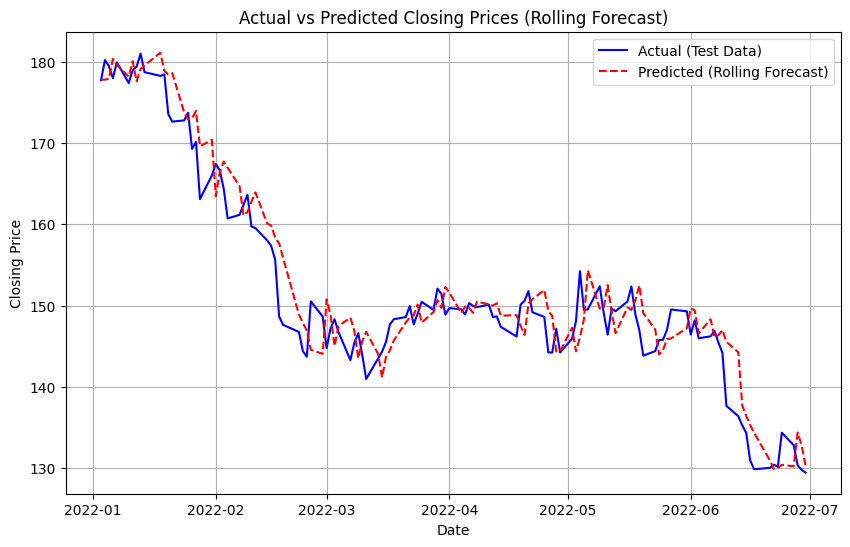

Mean Absolute Percentage Error (MAPE) with Rolling Forecast: 1.77%


In [18]:
# Use closing prices for training and test data
closing_prices_train = train_mmm_data['Close']
closing_prices_test = test_mmm_data['Close']

# Initialize a list to store predictions
rolling_predictions = []

# Start rolling forecast
history = closing_prices_train.copy()  # Initial training data

for t in range(len(closing_prices_test)):
    # Fit the model using the current training data (history)
    ar_model = AutoReg(history, lags=1).fit()

    # Predict the next value (one step ahead)
    next_prediction = ar_model.predict(start=history.index[-1], end=history.index[-1])[0]

    # Append the prediction to the list
    rolling_predictions.append(next_prediction)

    # Add the actual test data point to the history (walk-forward)
    history = pd.concat([history, pd.Series(closing_prices_test.iloc[t], index=[closing_prices_test.index[t]])])

# Convert rolling predictions to a pandas series for plotting
rolling_predictions = pd.Series(rolling_predictions, index=closing_prices_test.index)

# Plot actual vs predicted values on test data
plt.figure(figsize=(10, 6))

# Plot actual closing prices from test data
plt.plot(closing_prices_test.index, closing_prices_test, label='Actual (Test Data)', color='blue')

# Plot rolling forecast predictions
plt.plot(rolling_predictions.index, rolling_predictions, label='Predicted (Rolling Forecast)', color='red', linestyle='--')

# Add labels and title
plt.title('Actual vs Predicted Closing Prices (Rolling Forecast)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Optionally, calculate Mean Absolute Percentage Error (MAPE) on test data
residuals = closing_prices_test - rolling_predictions
mape = (abs(residuals) / closing_prices_test).mean() * 100
print(f"Mean Absolute Percentage Error (MAPE) with Rolling Forecast: {mape:.2f}%")

This is pretty good, right? We are able to predict with just 1.77% error. However, I tried doing a simulation experiment where we followed this model predictions to make trades accordingly. The strategy is to invest and long the 10000 dollars worth of MMM stock if the predicted price tomorrow were to increase from today, or to divest and short the 10000 dollars worth of MMM stock if the predicted price tomorrow were to decrease from today.

In [19]:
# Starting capital
initial_capital = 10000
capital = initial_capital

# Store all profits or losses for each trade
trade_results = []

# Assume no position at the beginning
position = None  # 'long' or 'short'
entry_price = 0

# Simulate trades
for i in range(1, len(test_mmm_data)):
    actual_today = closing_prices_test.iloc[i-1]
    actual_tomorrow = closing_prices_test.iloc[i]
    predicted_today = rolling_predictions.iloc[i-1]
    predicted_tomorrow = rolling_predictions.iloc[i]
    
    # Determine trade direction based on predicted prices
    if predicted_tomorrow > predicted_today:  # Predicted price increase -> Go Long
        if position != 'long':  # Enter a long position
            position = 'long'
            entry_price = actual_today
        # Calculate profit/loss if the position is closed
        if i == len(test_mmm_data) - 1 or rolling_predictions.iloc[i+1] < predicted_tomorrow:  # Close position at the end or predicted decrease
            profit = (actual_tomorrow - entry_price) / entry_price * capital
            trade_results.append(profit)
            capital += profit  # Update capital
            position = None  # Close position
    elif predicted_tomorrow < predicted_today:  # Predicted price decrease -> Go Short
        if position != 'short':  # Enter a short position
            position = 'short'
            entry_price = actual_today
        # Calculate profit/loss if the position is closed
        if i == len(test_mmm_data) - 1 or rolling_predictions.iloc[i+1] > predicted_tomorrow:  # Close position at the end or predicted increase
            profit = (entry_price - actual_tomorrow) / entry_price * capital
            trade_results.append(profit)
            capital += profit  # Update capital
            position = None  # Close position

# Final capital after all trades
final_capital = capital

# Profit or loss summary
total_profit_or_loss = final_capital - initial_capital
percentage_return = (total_profit_or_loss / initial_capital) * 100

print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Capital: ${final_capital:.2f}")
print(f"Total Profit/Loss: ${total_profit_or_loss:.2f}")
print(f"Percentage Return: {percentage_return:.2f}%")

Initial Capital: $10000.00
Final Capital: $8603.38
Total Profit/Loss: $-1396.62
Percentage Return: -13.97%


The result was that we lost 1396 dollars! How come? This is because MAPE does not give us the directional accuracy of this model, and simply only gives us the percentage of the residual as a proportion of the actual data, and this residual is absolute, so devoid of direction. However, when it comes to trading, direction matters a lot, and hence I made another function that finds out the directional accuracy of this model, meaning how many times it predicted in the correct direction in a measure of percentage upon the sample space of how many actual test data there are.

In [20]:
# Calculate directional accuracy (whether the predicted direction matches actual direction)
correct_direction = (rolling_predictions.diff().dropna().apply(lambda x: 1 if x > 0 else -1) == closing_prices_test.diff().dropna().apply(lambda x: 1 if x > 0 else -1))

# Calculate percentage of correct predictions in terms of direction
directional_accuracy = correct_direction.mean() * 100
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

Directional Accuracy: 44.72%


Hence, directional accuracy wise, this model is not amazing because it only predicts in the correct direction error 44% of the time. I attempted to use another evaluator function that combines the MAPE and directional accuracy to test out how reliable the model is, which is hybrid directional symmetry. It gives a score between 0 and 1, where 1 means it is a perfect model, 0 means it is a really really poor model.

In [21]:
# Calculate MAPE
mape = (abs(closing_prices_test - rolling_predictions) / closing_prices_test).mean()

# Calculate directional accuracy
predicted_movements = rolling_predictions.diff().dropna()
actual_movements = closing_prices_test.diff().dropna()

correct_direction = (predicted_movements.apply(lambda x: 1 if x > 0 else -1) == actual_movements.apply(lambda x: 1 if x > 0 else -1))
directional_accuracy = correct_direction.mean()

# Hybrid Directional Symmetry (HDS)
hds = (1 - mape) * directional_accuracy

print(f"MAPE: {mape * 100:.2f}%")
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")
print(f"Hybrid Directional Symmetry (HDS): {hds:.2f}")

MAPE: 1.77%
Directional Accuracy: 44.72%
Hybrid Directional Symmetry (HDS): 0.44


Next, we are going to go into Moving Average model, and the difference is that moving average sees to it that, to derive the next closing price, you need to take the mu (some mean) that the entire model gravitates about, and a linear combination of errors in the previous lags multiplied with some co-efficients. Now, in order to choose your q, which is the lagged variables you want to include in this linear combination, you need to satisfy the condition of correlation between the current variable and the lagged variable of interest. We can check this via looking at your autocorrelation function. Does it shut off to 0 after a certain "q" number of lagged variables? Referring back to our graph of ACF, no it does not. Hence, moving average model might not be applicable because if it were to use it, we need to have so many moving averages till the autocorrelation decays to zero gradually and slowly at some large value q. 

That's when I realised, maybe the model is flawed because there was no stationarity when we checked, but we still went ahead with using the data without transforming it to ensure stationarity. I did transform it, however, to avoid stationarity. I want to now run ARIMA, basically ARMA, but on the first differences of the closing prices, instead of pure normal ARMA. Better yet, I want to try my hand at running SARIMA actually, but to do that, I need to test on whether or not my data is seasonal or not. My training data says it is not, but I do not know if my test data is. Hence, I need to go run this.

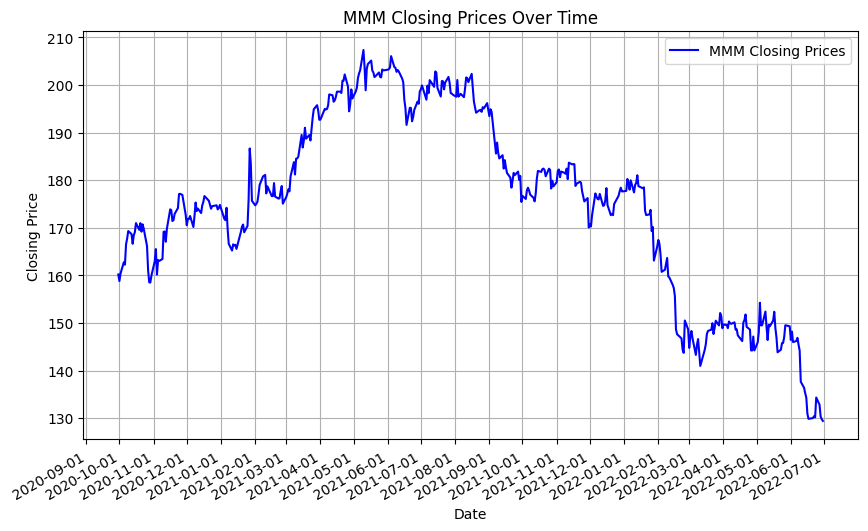

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'Date' column is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Filter for MMM's closing prices and set 'Date' as the index
mmm_data2 = merged_data[merged_data['Symbol'] == 'MMM'].set_index('Date')

# Plot the closing prices over time
plt.figure(figsize=(10, 6))
plt.plot(mmm_data2.index, mmm_data2['Close'], label='MMM Closing Prices', color='blue')

# Formatting the x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Labels and title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('MMM Closing Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()


From a visual check, there is no seasonality detected in this data. Hence, in fact there is no need to do a SARIMA. ARIMA would do just fine. Hence, I am going to take the first difference in my closing prices and check both ACF and PACF for them.

<Figure size 1000x600 with 0 Axes>

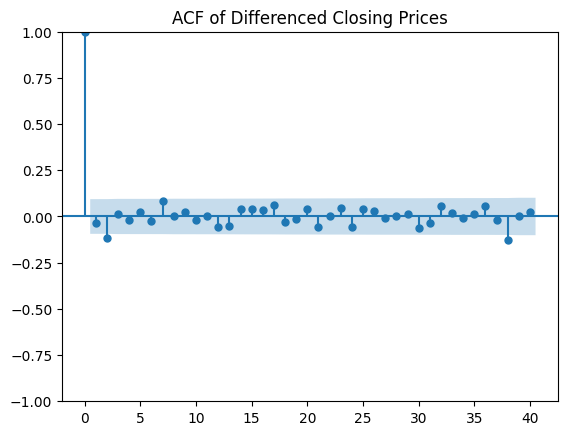

<Figure size 1000x600 with 0 Axes>

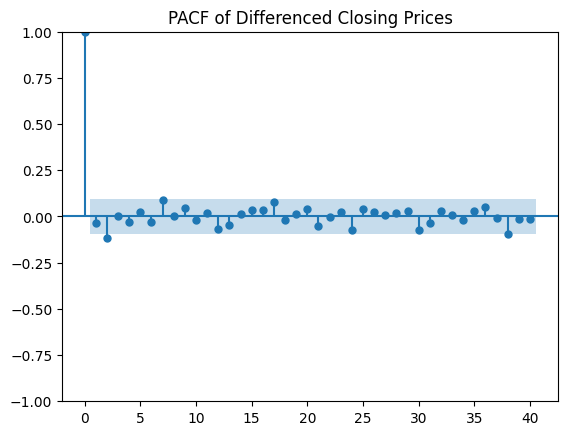

In [23]:
# Calculate the differences
mmm_data2['Diff_Close'] = mmm_data2['Close'].diff().dropna()

# Drop any NaN values that result from differencing
mmm_data2.dropna(inplace=True)

# Plot the ACF
plt.figure(figsize=(10, 6))
plot_acf(mmm_data2['Diff_Close'], lags=40)
plt.title('ACF of Differenced Closing Prices')
plt.show()

# Plot the PACF
plt.figure(figsize=(10, 6))
plot_pacf(mmm_data2['Diff_Close'], lags=40)
plt.title('PACF of Differenced Closing Prices')
plt.show()

From this I see that the lags 2 and 38 play the greatest part in both the ACF and PACF plot. Hence I am going to try doing an ARIMA model, with ARIMA(2,1,2) where p refers to the order of the AR, 1 refers to the dth difference of the integrated feature, q refers to the order of the MA. Specifically I want it to use the lagged variables 2 and 38. So let's try.

In [24]:
# Assuming 'Date' is already set as the index of mmm_data2 and it's in datetime format
training_data = mmm_data2[mmm_data2.index < '2022-01-01']


from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Fit a model with (38, 1, 38) on training data
model = SARIMAX(training_data['Close'], order=(38, 1, 38), enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)

# Extract the initial AR and MA coefficients
ar_params = result.params.filter(like='ar.L')
ma_params = result.params.filter(like='ma.L')

# Create arrays to hold the modified coefficients
custom_ar = np.zeros(38)  # Array to store AR parameters, with size up to lag 38
custom_ma = np.zeros(38)  # Array to store MA parameters, with size up to lag 38

# Retain coefficients only for lags 2, 7, and 38; set others to zero
for lag in [2, 7, 38]:
    if f"ar.L{lag}" in ar_params.index:
        custom_ar[lag - 1] = ar_params[f"ar.L{lag}"]
    if f"ma.L{lag}" in ma_params.index:
        custom_ma[lag - 1] = ma_params[f"ma.L{lag}"]

# Display manually adjusted coefficients
print("Adjusted AR coefficients (only lags 2, 7, 38):", custom_ar)
print("Adjusted MA coefficients (only lags 2, 7, 38):", custom_ma)


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

Adjusted AR coefficients (only lags 2, 7, 38): [ 0.         -0.27927713  0.          0.          0.          0.
  0.18237506  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.10801493]
Adjusted MA coefficients (only lags 2, 7, 38): [ 0.          0.09651487  0.          0.          0.          0.
 -0.10620194  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.03991105]


In [25]:
# Assuming 'Date' is already set as the index of mmm_data2 and it's in datetime format
test_data = mmm_data2[mmm_data2.index >= '2022-01-01']

# Forecasting on the test data length
forecast_steps = len(test_data)

# Use the model to make predictions
predictions = result.get_forecast(steps=forecast_steps)
predicted_values = predictions.predicted_mean

# Align predicted values with the test data index
predicted_values.index = test_data.index

# Print the predicted values
print(predicted_values)


Date
2022-01-03    177.073159
2022-01-04    178.128224
2022-01-05    178.362477
2022-01-06    178.678402
2022-01-07    179.943655
                 ...    
2022-06-24    176.826267
2022-06-27    177.261975
2022-06-28    176.947351
2022-06-29    177.064880
2022-06-30    177.190075
Name: predicted_mean, Length: 124, dtype: float64


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['Close'], predicted_values)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 17.76%


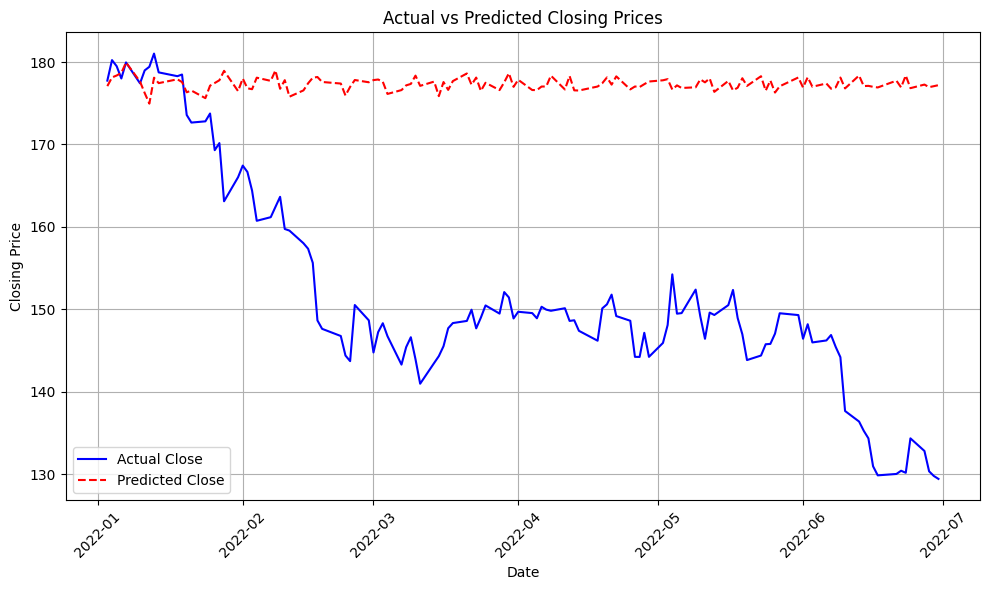

In [27]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Actual Close', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted Close', color='red', linestyle='--')

plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

After that I attempted to do a model whereby we solely just take 2, 7 and 38 as lagged variables, then do a rolling forecast. However, I realised that would be too time-consuming and this is not standard practice from research papers. Standard practices mentioned that I had to compare different ARIMAs from orders of 1 to 3, for both AR and MA.

In [28]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Function to calculate Adjusted R-Squared
def adjusted_r_squared(r_squared, n, k):
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

# Function to fit ARIMA model and return metrics including Adjusted R-Squared
def fit_arima_and_evaluate(order, training_data, test_data):
    # Fit the ARIMA model on training data
    model = SARIMAX(training_data['Close'], order=order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    
    # Generate predictions on the test data
    forecast = result.get_forecast(steps=len(test_data))
    predicted_mean = forecast.predicted_mean
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test_data['Close'], predicted_mean)
    
    # Calculate R-Squared
    r_squared = r2_score(test_data['Close'], predicted_mean)
    
    # Calculate Adjusted R-Squared
    n = len(test_data)  # Number of observations in the test set
    k = len(result.params) - 1  # Number of parameters in the model (excluding intercept)
    adj_r_squared = adjusted_r_squared(r_squared, n, k)
    
    aic = result.aic

    return mape, r_squared, adj_r_squared, aic 

# Function to perform rolling forecast evaluation including Adjusted R-Squared
def rolling_forecast_evaluation(order, training_data, test_data):
    history = list(training_data['Close'])
    predictions = []
    aic_values = []

    for t in range(len(test_data)):
        model = SARIMAX(history, order=order, enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        
        # Make one-step forecast
        yhat = result.forecast(steps=1)[0]
        predictions.append(yhat)

        # Store AIC for each rolling model
        aic_values.append(result.aic)
        
        # Update the history with the observed value
        history.append(test_data['Close'].iloc[t])

    # Calculate MAPE and R-Squared for rolling forecast
    mape = mean_absolute_percentage_error(test_data['Close'], predictions)
    r_squared = r2_score(test_data['Close'], predictions)
    
    # Calculate Adjusted R-Squared for rolling forecast
    n = len(test_data)  # Number of observations in the test set
    k = len(result.params) - 1  # Number of parameters in the model (excluding intercept)
    adj_r_squared = adjusted_r_squared(r_squared, n, k)

    # Calculate average AIC for rolling forecast
    avg_aic = sum(aic_values) / len(aic_values) if aic_values else None
    
    
    return mape, r_squared, adj_r_squared, avg_aic 

# Define the ARIMA configurations to test
arima_orders = [
    (1, 1, 1), (2, 1, 1), (3, 1, 1),
    (1, 1, 2), (1, 1, 3), (2, 1, 2),
    (2, 1, 3), (3, 1, 2), (3, 1, 3)
]

# Store results
results = []

# Loop through each ARIMA configuration
for order in arima_orders:
    print(f"Evaluating ARIMA{order}...")
    
    # Evaluation on direct test data predictions
    mape_test, r2_test, adj_r2_test, aic_test  = fit_arima_and_evaluate(order, training_data, test_data)
    
    # Evaluation on rolling forecast
    mape_rolling, r2_rolling, adj_r2_rolling, avg_aic_rolling = rolling_forecast_evaluation(order, training_data, test_data)
    
    # Store results
    results.append({
        'Order': order,
        'MAPE (Test Data)': mape_test,
        'R-Squared (Test Data)': r2_test,
        'Adjusted R-Squared (Test Data)': adj_r2_test,
        'AIC (Test Data)': aic_test,
        'MAPE (Rolling)': mape_rolling,
        'R-Squared (Rolling)': r2_rolling,
        'Adjusted R-Squared (Rolling)': adj_r2_rolling,
        'AIC (Rolling)': avg_aic_rolling
    })

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
print(results_df)


Evaluating ARIMA(1, 1, 1)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(2, 1, 1)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(3, 1, 1)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(1, 1, 2)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(1, 1, 3)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(2, 1, 2)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(2, 1, 3)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(3, 1, 2)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


Evaluating ARIMA(3, 1, 3)...


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


       Order  MAPE (Test Data)  R-Squared (Test Data)  \
0  (1, 1, 1)          0.178756              -4.058212   
1  (2, 1, 1)          0.179937              -4.124141   
2  (3, 1, 1)          0.179867              -4.120174   
3  (1, 1, 2)          0.179721              -4.112046   
4  (1, 1, 3)          0.180071              -4.131726   
5  (2, 1, 2)          0.178953              -4.069443   
6  (2, 1, 3)          0.179767              -4.114768   
7  (3, 1, 2)          0.179969              -4.126130   
8  (3, 1, 3)          0.179288              -4.088013   

   Adjusted R-Squared (Test Data)  AIC (Test Data)  MAPE (Rolling)  \
0                       -4.141819      1360.420044        0.012136   
1                       -4.252245      1359.203595        0.012083   
2                       -4.292281      1357.487069        0.012116   
3                       -4.239847      1355.329423        0.012120   
4                       -4.304221      1349.956386        0.011991   
5        

With all the evaluations done above, I have come to a conclusion that in terms of rolling forecast, an ARIMA model of (1,1,3) is the best, as it gave a very competitive R-squared and also the lowest MAPE and AIC. 

C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


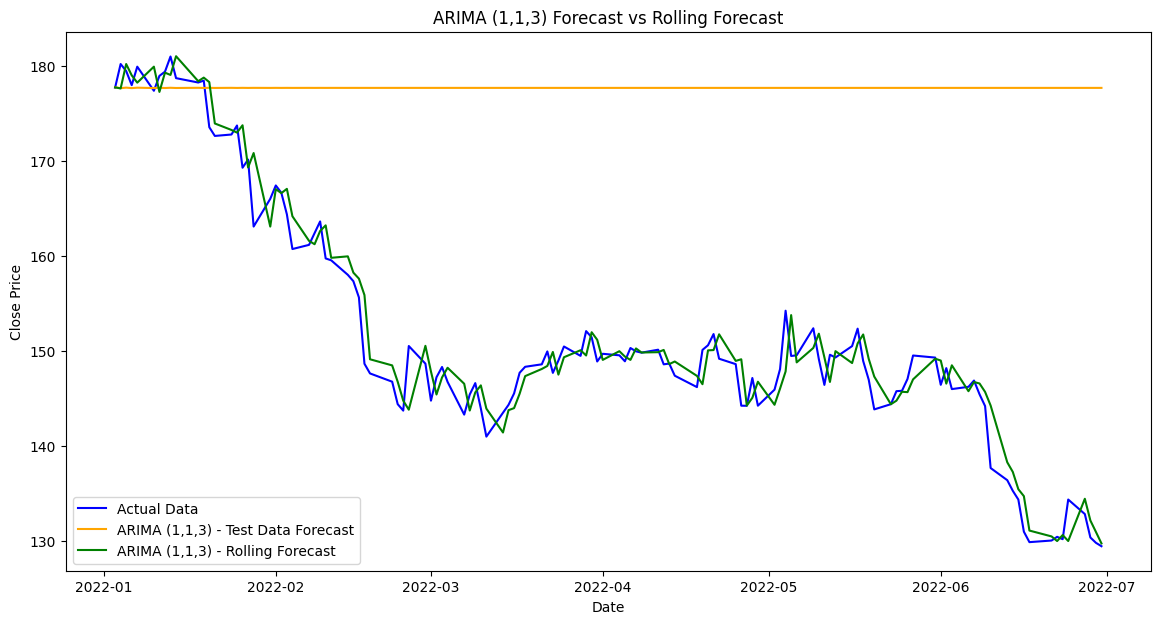

In [29]:
import matplotlib.pyplot as plt

# Define the order for the model you want to plot
selected_order = (1, 1, 3)

# Run the evaluation to get the predictions for both test data and rolling forecast
mape_test, r2_test, adj_r2_test, aic_test = fit_arima_and_evaluate(selected_order, training_data, test_data)
mape_rolling, r2_rolling, adj_r2_rolling, avg_aic_rolling = rolling_forecast_evaluation(selected_order, training_data, test_data)

# Generate predictions for direct ARIMA forecast (test data)
model = SARIMAX(training_data['Close'], order=selected_order, enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)
forecast = result.get_forecast(steps=len(test_data))
predicted_mean_test = forecast.predicted_mean

# Generate predictions for rolling forecast
history = list(training_data['Close'])
predictions_rolling = []

for t in range(len(test_data)):
    model = SARIMAX(history, order=selected_order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    yhat = result.forecast(steps=1)[0]
    predictions_rolling.append(yhat)
    history.append(test_data['Close'].iloc[t])

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual test data
plt.plot(test_data.index, test_data['Close'], label='Actual Data', color='blue')

# Plot direct ARIMA test data predictions
plt.plot(test_data.index, predicted_mean_test, label='ARIMA (1,1,3) - Test Data Forecast', color='orange')

# Plot rolling forecast predictions
plt.plot(test_data.index, predictions_rolling, label='ARIMA (1,1,3) - Rolling Forecast', color='green')

# Add titles and labels
plt.title('ARIMA (1,1,3) Forecast vs Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Show the plot
plt.show()

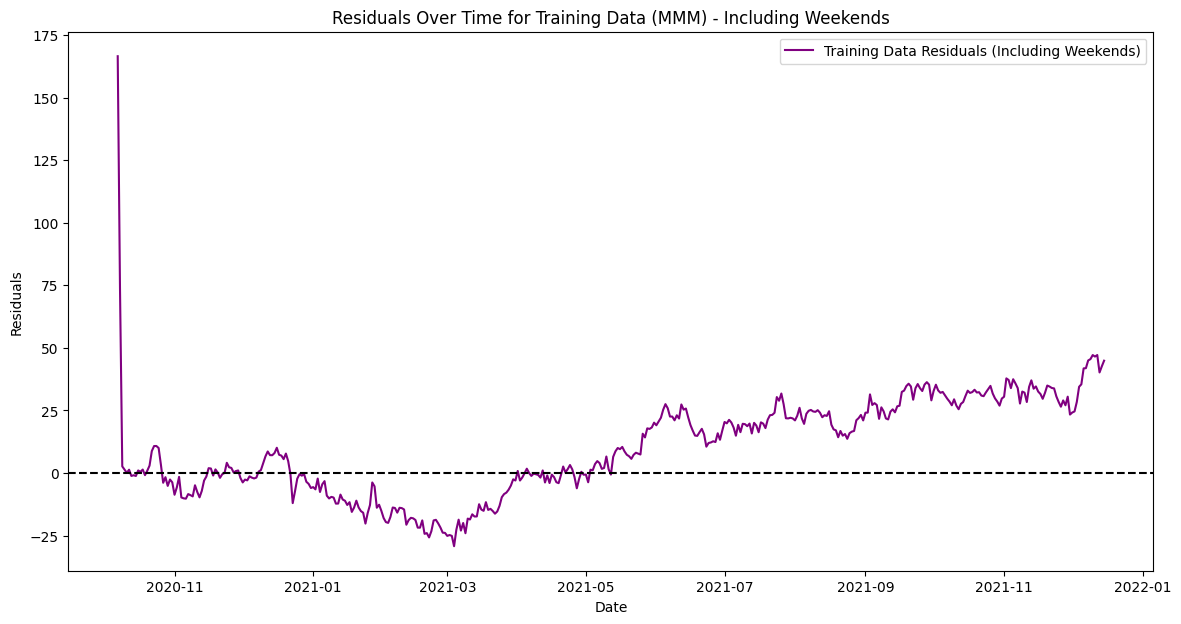

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a date range that includes all days (including weekends) in the training data period
full_date_range = pd.date_range(start=training_data.index.min(), end=training_data.index.max(), freq='D')

# Reindex training_data to include all dates in the range, and forward-fill missing weekend values
training_data_full = training_data.reindex(full_date_range).ffill()

# Now, align the fitted values from the ARIMA model with this updated training data
train_fitted_values = pd.Series(result.fittedvalues, index=training_data_full.index[:len(result.fittedvalues)])

# Calculate residuals with this new, weekend-included training data
train_residuals = training_data_full['Close'] - train_fitted_values

# Plot the residuals
plt.figure(figsize=(14, 7))
plt.plot(train_residuals.index, train_residuals, label="Training Data Residuals (Including Weekends)", color="purple")
plt.axhline(y=0, color='black', linestyle='--')  # Horizontal line at zero for reference
plt.title("Residuals Over Time for Training Data (MMM) - Including Weekends")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()


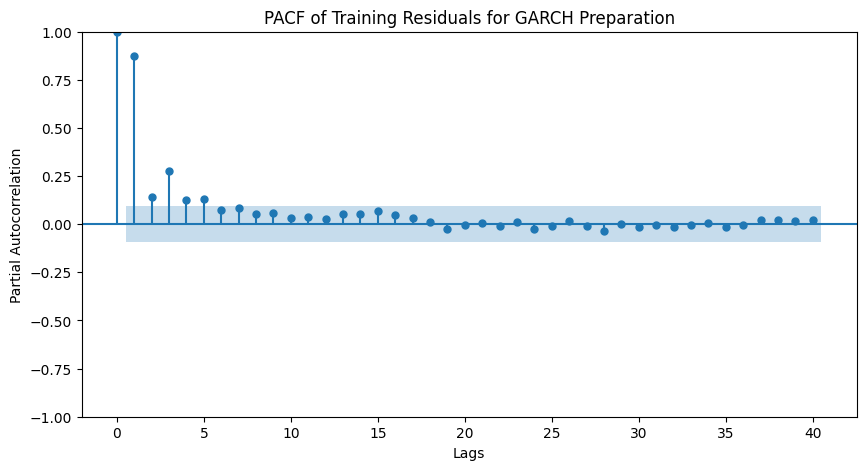

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Plot PACF for the training residuals to prepare for GARCH
plt.figure(figsize=(10, 5))
plot_pacf(train_residuals.dropna(), lags=40, ax=plt.gca(), title="PACF of Training Residuals for GARCH Preparation")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()



Since PACF shuts off somewhat after 3, we are going to go with GARCH of p=3. As for q, I have decided to try 1 first. Let's see how that goes!

In [32]:
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Ensure that train_residuals are defined (residuals from ARIMA model fitted on training data)

# Step 2: Fit the GARCH(3,1) model on the training data residuals
garch_model = arch_model(train_residuals.dropna(), vol='Garch', p=3, q=1)  # vol='Garch' specifies a GARCH model
garch_result = garch_model.fit(disp='off')  # disp='off' to suppress output

# Step 3: Display the GARCH model summary
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1736.39
Distribution:                  Normal   AIC:                           3484.79
Method:            Maximum Likelihood   BIC:                           3509.24
                                        No. Observations:                  435
Date:                Thu, Oct 31 2024   Df Residuals:                      434
Time:                        17:00:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2164      0.573     -0.377      0.706 [ -1.340,  0.90

Since the beta coefficient is very small and alpha 3 coefficient is also small, and their p-values are very big, we are going to drop them and retire to an ARCH of (2,0) instead.

In [33]:

# Step 2: Fit the GARCH(2,0) model on the training data residuals
garch_model = arch_model(train_residuals.dropna(), vol='Garch', p=2, q=0)  # vol='Garch' specifies a GARCH model
garch_result = garch_model.fit(disp='off')  # disp='off' to suppress output

# Step 3: Display the GARCH model summary
print(garch_result.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1755.42
Distribution:                  Normal   AIC:                           3518.83
Method:            Maximum Likelihood   BIC:                           3535.13
                                        No. Observations:                  435
Date:                Thu, Oct 31 2024   Df Residuals:                      434
Time:                        17:00:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            19.0213      1.937      9.821  9.165e-23 [ 15.225, 22.81

Now we have a high p-value for alpha 2 and a low coefficient for it too. So let's just do ARCH 1.

In [34]:

# Step 2: Fit the GARCH(2,0) model on the training data residuals
garch_model = arch_model(train_residuals.dropna(), vol='Garch', p=1, q=0)  # vol='Garch' specifies a GARCH model
garch_result = garch_model.fit(disp='off')  # disp='off' to suppress output

# Step 3: Display the GARCH model summary
print(garch_result.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1738.77
Distribution:                  Normal   AIC:                           3483.54
Method:            Maximum Likelihood   BIC:                           3495.77
                                        No. Observations:                  435
Date:                Thu, Oct 31 2024   Df Residuals:                      434
Time:                        17:00:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2510      0.694      0.362      0.718 [ -1.109,  1.61

Date
2022-01-03   -0.030671
2022-01-04    2.546266
2022-01-05    1.750251
2022-01-06    0.309251
2022-01-07    2.216382
dtype: float64


C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


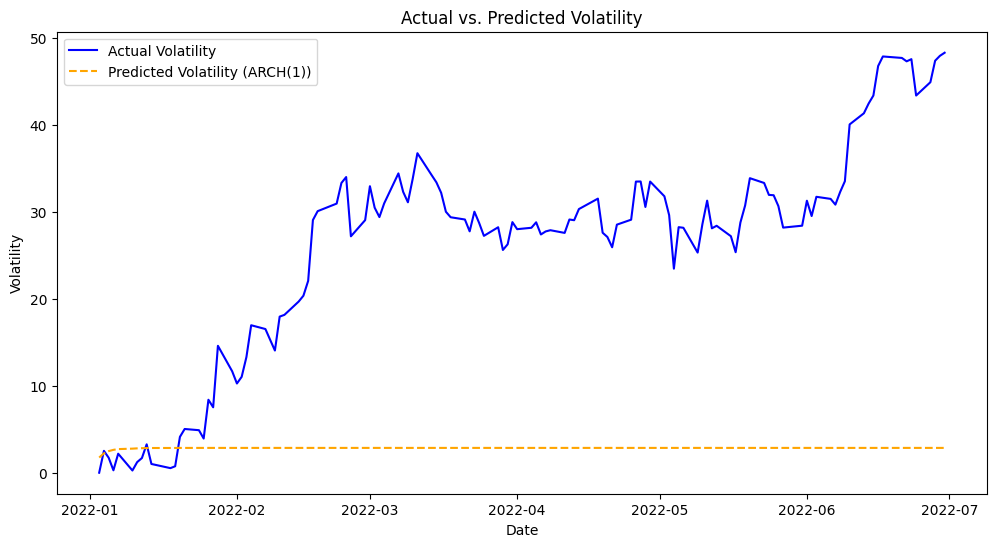

In [43]:

# Fit the ARIMA model on the training data
model = SARIMAX(training_data['Close'], order=selected_order, enforce_stationarity=False, enforce_invertibility=False)
fitted_model = model.fit(disp=False)

# Forecast for the test data period
forecast = fitted_model.get_forecast(steps=len(test_data))
predicted_mean_test = forecast.predicted_mean

# Align indexes of forecasted values with test data
predicted_mean_test.index = test_data.index

# Calculate test residuals
test_residuals = test_data['Close'] - predicted_mean_test

# Print the first few test residuals to verify
print(test_residuals.head())

# Assuming you already have the fitted ARCH(1) model on the training residuals
# Forecast the conditional volatility for the test data period
# `horizon` is the length of the test data
forecast_horizon = len(test_data)
arch_forecast = garch_result.forecast(horizon=forecast_horizon)

# Extract the predicted conditional volatility for the test period
predicted_volatility = np.sqrt(arch_forecast.variance.values[-forecast_horizon:])  # Take the square root to get standard deviation

# Ensure predicted_volatility is one-dimensional
predicted_volatility = predicted_volatility.flatten()

# Calculate the actual volatility from test data
# You can use the squared residuals from the ARIMA model on the test data as a proxy for actual volatility
# This assumes `test_residuals` has been computed as `test_data['Close'] - predicted_values_from_ARIMA`
actual_volatility = np.sqrt(test_residuals ** 2)

# Plot the actual vs. predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_volatility, label='Actual Volatility', color='blue')
plt.plot(test_data.index, predicted_volatility, label='Predicted Volatility (ARCH(1))', color='orange', linestyle='--')
plt.title('Actual vs. Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


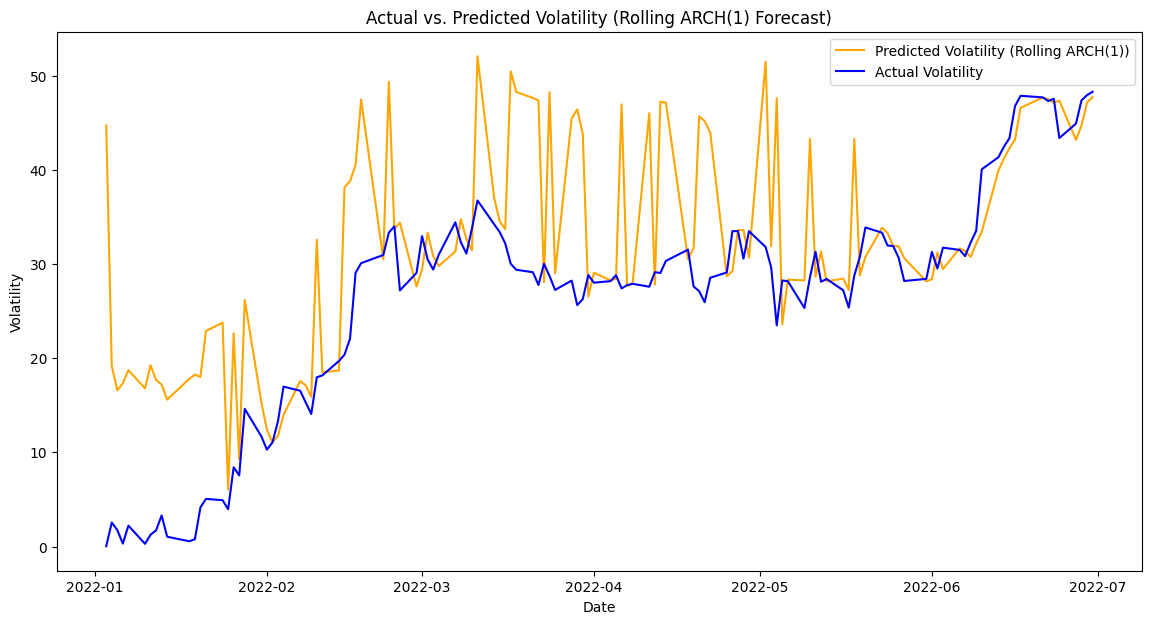

In [46]:
# Fit initial ARCH(1) model on the training residuals
arch_model_fitted = arch_model(train_residuals.dropna(), vol='Garch', p=1, q=0).fit(disp="off")

# Prepare a list to store predicted volatilities
rolling_volatility_forecast = []

# Rolling forecast over the test data
history_residuals = list(train_residuals.dropna())  # Start with training residuals

for t in range(len(test_data)):
    # Update the ARCH model with the current residual history
    rolling_arch_model = arch_model(history_residuals, vol='Garch', p=1, q=0).fit(disp="off")
    
    # Forecast the next period's volatility
    forecast = rolling_arch_model.forecast(horizon=1)
    next_volatility = np.sqrt(forecast.variance.values[-1, 0])  # Standard deviation (volatility)
    
    # Append the predicted volatility for this step
    rolling_volatility_forecast.append(next_volatility)
    
    # Update history with the actual residual of the test set (from the ARIMA prediction)
    # This requires you to have ARIMA predicted residuals on the test data
    test_residual = test_data['Close'].iloc[t] - predicted_mean_test.iloc[t]  # Residual on test data
    history_residuals.append(test_residual)

# Convert rolling volatility forecast to a DataFrame for easier plotting
rolling_volatility_forecast = pd.Series(rolling_volatility_forecast, index=test_data.index)

# Plot the actual vs predicted volatility over the test period
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, rolling_volatility_forecast, label='Predicted Volatility (Rolling ARCH(1))', color='orange')
plt.plot(test_data.index, actual_volatility, label='Actual Volatility', color='blue')
plt.title('Actual vs. Predicted Volatility (Rolling ARCH(1) Forecast)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()











C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

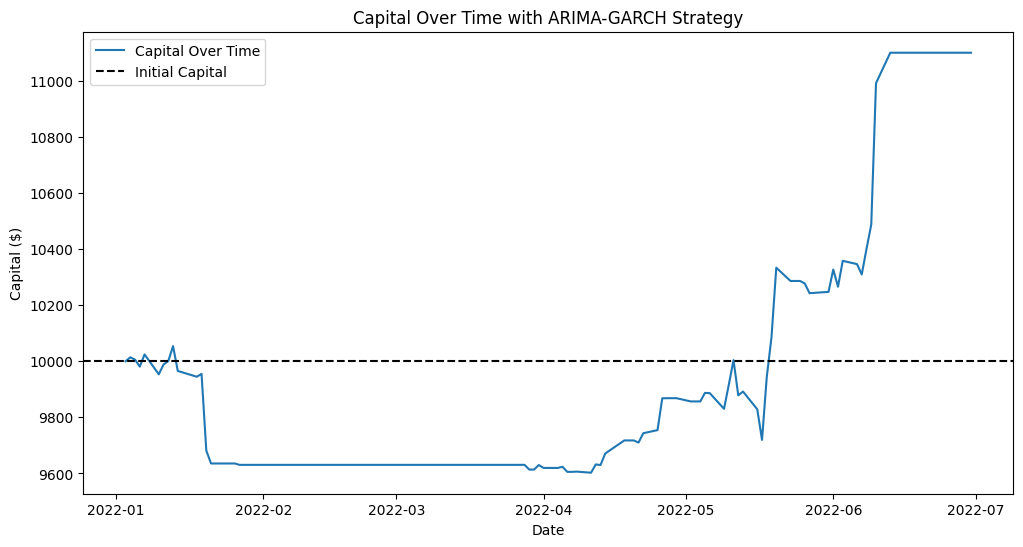

Final Capital: $11100.58


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Define initial capital
initial_capital = 10000
capital = initial_capital
position = 0  # Position in stock (positive for long, negative for short)
position_value = 0  # Value of the position in dollars
cash = capital  # Cash in hand

# Prepare a list to store capital over time
capital_history = []

# Fit the ARIMA model on training data
fitted_model = ARIMA(training_data['Close'], order=(1, 1, 3)).fit()

# Obtain training residuals
train_residuals = training_data['Close'] - fitted_model.fittedvalues

# Fit initial ARCH(1) model on the training residuals
arch_model_fitted = arch_model(train_residuals.dropna(), vol='Garch', p=1, q=0).fit(disp="off")

# Rolling forecast for ARIMA and GARCH
history_residuals = list(train_residuals.dropna())  # Start with training residuals
historical_volatility = []

# Perform rolling simulation on the test data
for t in range(len(test_data)):
    # Update ARIMA forecast
    arima_forecast = fitted_model.forecast(steps=1).iloc[0]
    
    # Update ARCH model with history and forecast volatility
    rolling_arch_model = arch_model(history_residuals, vol='Garch', p=1, q=0).fit(disp="off")
    garch_forecast = rolling_arch_model.forecast(horizon=1).variance.iloc[-1, 0]
    predicted_volatility = np.sqrt(garch_forecast)  # Standard deviation of volatility
    
    # Add the predicted volatility to historical_volatility for threshold calculation
    historical_volatility.append(predicted_volatility)
    volatility_threshold = np.mean(historical_volatility)*1.5  # Average historical volatility
    
    daily_return = (test_data['Close'].iloc[t] - arima_forecast) / arima_forecast
    
    # Trading logic based on ARIMA prediction and GARCH volatility forecast
    if daily_return > 0 and predicted_volatility < volatility_threshold:
        # Buy signal with increased position for lower volatility
        position_size = capital * 0.1
        position += position_size / test_data['Close'].iloc[t]
        cash -= position_size
    elif daily_return < 0 and predicted_volatility < volatility_threshold:
        # Short signal with increased position for lower volatility
        position_size = capital * 0.1
        position -= position_size / test_data['Close'].iloc[t]
        cash += position_size
    elif predicted_volatility > volatility_threshold:
        # Exit all positions if volatility is high
        cash += position * test_data['Close'].iloc[t]
        position = 0  # Reset position to zero

    # Update capital based on new position
    position_value = position * test_data['Close'].iloc[t]
    capital = cash + position_value
    capital_history.append(capital)
    
    # Append the residual of the test data
    test_residual = test_data['Close'].iloc[t] - arima_forecast
    history_residuals.append(test_residual)

# Convert capital history to a DataFrame for plotting
capital_history = pd.Series(capital_history, index=test_data.index)

# Plot the capital over time
plt.figure(figsize=(12, 6))
plt.plot(capital_history, label='Capital Over Time')
plt.axhline(y=initial_capital, color='black', linestyle='--', label='Initial Capital')
plt.title('Capital Over Time with ARIMA-GARCH Strategy')
plt.xlabel('Date')
plt.ylabel('Capital ($)')
plt.legend()
plt.show()

# Final capital
final_capital = capital_history.iloc[-1]
print(f"Final Capital: ${final_capital:.2f}")

